In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.metrics import TopKCategoricalAccuracy
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# **PREPROCESSING FUNCTIONS FOR OUR MODEL**

In [ ]:
def strip_sequences(df, column_name):
  stripped_seq = df[column_name].apply(lambda x: [item.strip() for item in x.split(",")]).tolist()
  return stripped_seq

In [ ]:
from collections import defaultdict

def markov_mtrx(sequence):

  transitions = defaultdict(lambda: defaultdict(int))

  unique_calls = []
  for i in range(len(sequence) - 1):
    current_call = sequence[i]
    next_call = sequence[i+1]
    transitions[current_call][next_call] += 1
    if current_call not in unique_calls:
      unique_calls.append(current_call)

  df_probabilities = pd.DataFrame(index=unique_calls, columns=unique_calls)

  for row in unique_calls:
      total_transitions = sum(transitions[row].values())
      for col in unique_calls:
          if total_transitions > 0:
              df_probabilities.at[row, col] = transitions[row][col] / total_transitions
          else:
              df_probabilities.at[row, col] = 0

  df_probabilities = df_probabilities.fillna(0)
  return df_probabilities

In [ ]:
def create_markov_mrtx_list(data):
  datalist = []
  for sequence in data:
    datalist.append(markov_mtrx(sequence).values)

  return datalist

In [ ]:
def scale_values(matrix):
  return (matrix * 255).astype(np.uint8)

In [ ]:
from PIL import Image
import numpy as np

def create_image(scaled_matrix):

  image = Image.fromarray(scaled_matrix, mode='L')  # 'L' mode is for grayscale

  return image

In [ ]:
def images_max_size(images):
  tuple_seq = []
  for image in images:
    tuple_seq.append(image.size)

  return max(tuple_seq, key=lambda x: x[1])

In [ ]:
import cv2

def add_padding(image, max_size):
  image_np = np.array(image)

  if image.size == max_size:
    return image
  else:
    pad_width = max_size[0] - image.size[0]
    pad_height = max_size[1] - image.size[1]

    top_pad = pad_height // 2
    bottom_pad = pad_height - top_pad
    left_pad = pad_width // 2
    right_pad = pad_width - left_pad

    padded_image = cv2.copyMakeBorder(image_np, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=0)
    return Image.fromarray(padded_image)

In [ ]:
def convert_images_to_arrays(image_objects):
    image_arrays = []
    for img_obj in image_objects:
        img_array = np.array(img_obj)
        image_arrays.append(img_array)
    return np.array(image_arrays)

In [ ]:
from tensorflow.keras.layers import BatchNormalization

def build_CNN(outputs, height, width, channels):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(outputs, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# **OUR MODEL WITH OUR DATASET**

* #### **Precision:** 0.9266
* #### **Accuracy:** 0.9215
* #### **Recall:** 0.9215
* #### **F1-Score:** 0.9218
* #### **Precision Standard Deviation:** 0.059
* #### **Accuracy Standard Deviation:** 0.063
* #### **Recall Standard Deviation:** 0.063
* #### **F1-Score Standard Deviation:** 0.063


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Samples/Family_Dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      1956 non-null   object
 1   Sequence  1949 non-null   object
 2   Label     1956 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 46.0+ KB


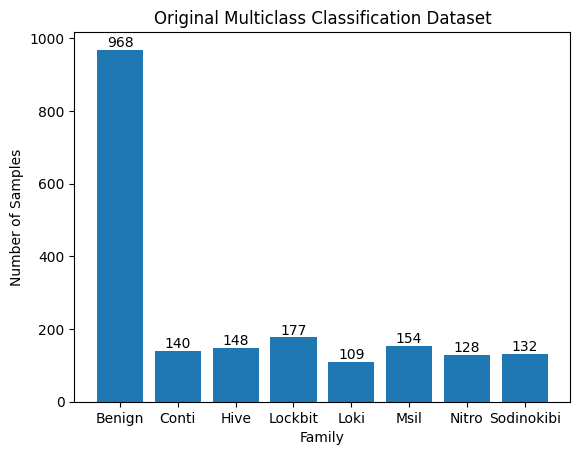

In [ ]:
label_counts = df['Label'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Family')
plt.ylabel('Number of Samples')
plt.title('Original Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ["Benign", "Conti", "Hive", "Lockbit", "Loki", "Msil", "Nitro", "Sodinokibi"])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
df.dropna(inplace=True)

X = df.drop('Label', axis=1)
y = df['Label']

rus = RandomUnderSampler(sampling_strategy='not minority', random_state=22)

X_resampled, y_resampled = rus.fit_resample(X, y)

df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Label'])], axis=1)

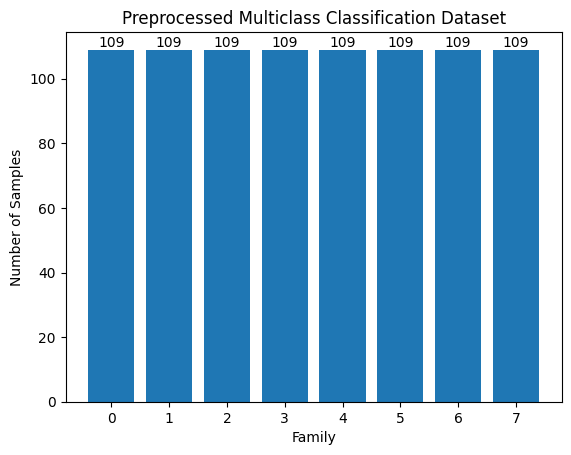

In [ ]:
label_counts = df['Label'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Family')
plt.ylabel('Number of Samples')
plt.title('Preprocessed Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
data = strip_sequences(df=df, column_name="Sequence")
a = create_markov_mrtx_list(data)
scaled_a = []

for element in a:
  scaled_a.append(scale_values(element))

In [ ]:
images_a = []
for i in scaled_a:
  images_a.append(create_image(i))

In [ ]:
padded_imgs = []
for image in images_a:
  padded_imgs.append(add_padding(image, images_max_size(images_a)))

In [ ]:
df["Image"] = images_a

In [ ]:
df["Padded_Image"] = padded_imgs

In [ ]:
avg_p = []
avg_a = []
avg_r = []
avg_f = []

precision_values = []
accuracy_values = []
recall_values = []
f1_values = []

X, y = convert_images_to_arrays(df["Padded_Image"]), np.array(df["Label"].tolist())

num_folds = 3

for i in range(10):
  print("Running iteration number:", i)
  kf = KFold(n_splits=num_folds, shuffle=True, random_state=22)

  precisions = []
  accuracies = []
  recalls = []
  f1s = []

  model = build_CNN(8, 123, 123, 1)

  fold_number = 1
  for train_index, test_index in kf.split(X):

    print(f"Fold: {fold_number}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

    model.fit(X_train, y_train, verbose=1, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

    predictions = model.predict(X_test)

    multiclass_predictions = np.argmax(predictions, axis=1)

    precision = precision_score(y_test, multiclass_predictions, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test, multiclass_predictions)
    recall = recall_score(y_test, multiclass_predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, multiclass_predictions, average='weighted')

    print(precision, accuracy)

    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    fold_number = fold_number + 1

  avg_p.append(np.mean(precisions))
  avg_a.append(np.mean(accuracies))
  avg_r.append(np.mean(recalls))
  avg_f.append(np.mean(f1s))

  precision_values.extend(precisions)
  accuracy_values.extend(accuracies)
  recall_values.extend(recalls)
  f1_values.extend(f1s)

Running iteration number: 0
Fold: 1
Epoch 1/20
19/19 [==============================] - 33s 2s/step - loss: 5.8292 - accuracy: 0.4475 - val_loss: 8.1113 - val_accuracy: 0.4227
Epoch 2/20
19/19 [==============================] - 29s 2s/step - loss: 0.8831 - accuracy: 0.7418 - val_loss: 4.4053 - val_accuracy: 0.5292
Epoch 3/20
19/19 [==============================] - 28s 2s/step - loss: 0.3935 - accuracy: 0.8744 - val_loss: 2.1575 - val_accuracy: 0.6254
Epoch 4/20
19/19 [==============================] - 30s 2s/step - loss: 0.2122 - accuracy: 0.9398 - val_loss: 1.4457 - val_accuracy: 0.7182
Epoch 5/20
19/19 [==============================] - 30s 2s/step - loss: 0.2317 - accuracy: 0.9329 - val_loss: 1.0439 - val_accuracy: 0.7835
Epoch 6/20
19/19 [==============================] - 27s 1s/step - loss: 0.1462 - accuracy: 0.9639 - val_loss: 0.8185 - val_accuracy: 0.7732
Epoch 7/20
19/19 [==============================] - 30s 2s/step - loss: 0.0638 - accuracy: 0.9811 - val_loss: 0.7070 - val_a

In [ ]:
precision_min = np.min(precision_values)
precision_max = np.max(precision_values)
precision_std = np.std(precision_values)

accuracy_min = np.min(accuracy_values)
accuracy_max = np.max(accuracy_values)
accuracy_std = np.std(accuracy_values)

recall_min = np.min(recall_values)
recall_max = np.max(recall_values)
recall_std = np.std(recall_values)

f1_min = np.min(f1_values)
f1_max = np.max(f1_values)
f1_std = np.std(f1_values)

In [ ]:
print(f'The precision values after 10 runs are -> Min: {np.min(precision_values)}, Mean: {np.mean(avg_p)}, Max: {np.max(precision_values)}, Std: {np.std(precision_values)}')
print(f'The accuracy values after 10 runs are -> Min: {np.min(accuracy_values)}, Mean: {np.mean(avg_a)}, Max: {np.max(accuracy_values)}, Std: {np.std(accuracy_values)}')
print(f'The recall values after 10 runs are -> Min: {np.min(recall_values)}, Mean: {np.mean(avg_r)}, Max: {np.max(recall_values)}, Std: {np.std(recall_values)}')
print(f'The F1 values after 10 runs are -> Min: {np.min(f1_values)}, Mean: {np.mean(avg_f)}, Max: {np.max(f1_values)}, Std: {np.std(f1_values)}')

The precision values after 10 runs are -> Min: 0.8282139623614589, Mean: 0.9266290395593183, Max: 0.9934571175950486, Std: 0.05864878849645921
The accuracy values after 10 runs are -> Min: 0.8041237113402062, Mean: 0.9215108425168859, Max: 0.993103448275862, Std: 0.06293928160695283
The recall values after 10 runs are -> Min: 0.8041237113402062, Mean: 0.9215108425168859, Max: 0.993103448275862, Std: 0.06293928160695283
The F1 values after 10 runs are -> Min: 0.8069347938884323, Mean: 0.9217719728797252, Max: 0.993144048850734, Std: 0.06250851133976898


## Only to save the images

In [ ]:
for index, row in df.iterrows():
    name = row['Name']
    img = row['Padded_Image']
    if row['Label'] == 0:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Safe/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 1:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Conti/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 2:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Hive/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 3:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Lockbit/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 4:
        img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Loki/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 5:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Msil/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 6:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Nitro/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 7:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Sodinokibi/"+name.strip(".json")+".jpeg")

# **OUR MODEL WITH COGLIO'S DATASET**

* #### **Precision:** 0.8255
* #### **Accuracy:** 0.8042
* #### **Recall:** 0.8042
* #### **F1-Score:** 0.8060
* #### **Precision Standard Deviation:** 0.075
* #### **Accuracy Standard Deviation:** 0.085
* #### **Recall Standard Deviation:** 0.085
* #### **F1-Score Standard Deviation:** 0.085

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Samples/Comparison/Filippo_Dataset_for_My_Model.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5203 entries, 0 to 5202
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      5203 non-null   object
 1   Sequence  5194 non-null   object
 2   Label     5203 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 122.1+ KB


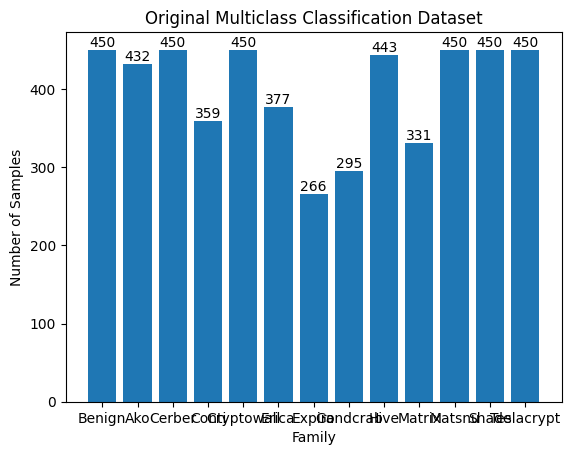

In [ ]:
label_counts = df['Label'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Family')
plt.ylabel('Number of Samples')
plt.title('Original Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ["Benign", "Ako", "Cerber", "Conti", "Cryptowall", "Erica", "Expiro", "Gandcrab", "Hive", "Matrix", "Matsnu", "Shade", "Teslacrypt"])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
df.dropna(inplace=True)

X = df.drop('Label', axis=1)
y = df['Label']

rus = RandomUnderSampler(sampling_strategy='not minority', random_state=22)

X_resampled, y_resampled = rus.fit_resample(X, y)

df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Label'])], axis=1)

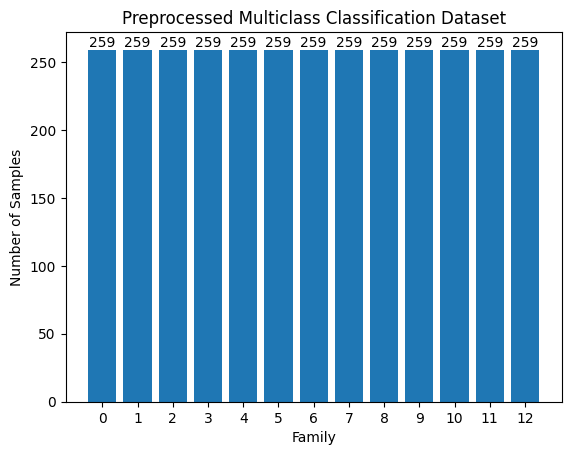

In [ ]:
label_counts = df['Label'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Family')
plt.ylabel('Number of Samples')
plt.title('Preprocessed Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
data = strip_sequences(df=df, column_name="Sequence")
a = create_markov_mrtx_list(data)
scaled_a = []

for element in a:
  scaled_a.append(scale_values(element))

In [ ]:
images_a = []
for i in scaled_a:
  images_a.append(create_image(i))

In [ ]:
padded_imgs = []
for image in images_a:
  padded_imgs.append(add_padding(image, images_max_size(images_a)))

In [ ]:
df["Image"] = images_a

In [ ]:
df["Padded_Image"] = padded_imgs

In [ ]:
avg_p = []
avg_a = []
avg_r = []
avg_f = []

precision_values = []
accuracy_values = []
recall_values = []
f1_values = []

X, y = convert_images_to_arrays(df["Padded_Image"]), np.array(df["Label"].tolist())

num_folds = 7

for i in range(3):
  print("Running iteration number:", i)
  kf = KFold(n_splits=num_folds, shuffle=True, random_state=22)

  precisions = []
  accuracies = []
  recalls = []
  f1s = []

  model = build_CNN(13, 136, 136, 1)

  fold_number = 1
  for train_index, test_index in kf.split(X):

    print(f"Fold: {fold_number}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

    model.fit(X_train, y_train, verbose=1, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

    predictions = model.predict(X_test)

    multiclass_predictions = np.argmax(predictions, axis=1)

    precision = precision_score(y_test, multiclass_predictions, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test, multiclass_predictions)
    recall = recall_score(y_test, multiclass_predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, multiclass_predictions, average='weighted')

    print(precision, accuracy)

    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    fold_number = fold_number + 1

  avg_p.append(np.mean(precisions))
  avg_a.append(np.mean(accuracies))
  avg_r.append(np.mean(recalls))
  avg_f.append(np.mean(f1s))

  precision_values.extend(precisions)
  accuracy_values.extend(accuracies)
  recall_values.extend(recalls)
  f1_values.extend(f1s)

Running iteration number: 0
Fold: 1
Epoch 1/20
91/91 [==============================] - 136s 1s/step - loss: 3.3834 - accuracy: 0.3274 - val_loss: 2.0555 - val_accuracy: 0.4054
Epoch 2/20
91/91 [==============================] - 126s 1s/step - loss: 1.5785 - accuracy: 0.5319 - val_loss: 1.5153 - val_accuracy: 0.5572
Epoch 3/20
91/91 [==============================] - 127s 1s/step - loss: 1.2135 - accuracy: 0.6438 - val_loss: 1.2976 - val_accuracy: 0.6320
Epoch 4/20
91/91 [==============================] - 129s 1s/step - loss: 1.0277 - accuracy: 0.6868 - val_loss: 1.6149 - val_accuracy: 0.6299
Epoch 5/20
91/91 [==============================] - 125s 1s/step - loss: 0.8771 - accuracy: 0.7380 - val_loss: 1.5899 - val_accuracy: 0.6279
Epoch 5: early stopping
16/16 [==============================] - 6s 336ms/step
0.6558643058552008 0.632016632016632
Fold: 2
Epoch 1/20
91/91 [==============================] - 130s 1s/step - loss: 1.0963 - accuracy: 0.6830 - val_loss: 1.5946 - val_accuracy: 0

In [ ]:
print(f'The precision values after 10 runs are -> Min: {np.min(precision_values)}, Mean: {np.mean(avg_p)}, Max: {np.max(precision_values)}, Std: {np.std(precision_values)}')
print(f'The accuracy values after 10 runs are -> Min: {np.min(accuracy_values)}, Mean: {np.mean(avg_a)}, Max: {np.max(accuracy_values)}, Std: {np.std(accuracy_values)}')
print(f'The recall values after 10 runs are -> Min: {np.min(recall_values)}, Mean: {np.mean(avg_r)}, Max: {np.max(recall_values)}, Std: {np.std(recall_values)}')
print(f'The F1 values after 10 runs are -> Min: {np.min(f1_values)}, Mean: {np.mean(avg_f)}, Max: {np.max(f1_values)}, Std: {np.std(f1_values)}')

The precision values after 10 runs are -> Min: 0.6558643058552008, Mean: 0.82552116935406, Max: 0.9288232855436532, Std: 0.07456374390269233
The accuracy values after 10 runs are -> Min: 0.632016632016632, Mean: 0.8041778041778042, Max: 0.9251559251559252, Std: 0.08506292218936656
The recall values after 10 runs are -> Min: 0.632016632016632, Mean: 0.8041778041778042, Max: 0.9251559251559252, Std: 0.08506292218936656
The F1 values after 10 runs are -> Min: 0.6241043802063729, Mean: 0.80598188640471, Max: 0.9248338860931264, Std: 0.08535132372409775


# **COGLIO'S MODEL WITH OUR DATASET**

* #### **Precision:** 0.8826
* #### **Accuracy:** 0.8741
* #### **Recall:** 0.8741
* #### **F1-Score:** 0.8739
* #### **Precision Standard Deviation:** 0.031
* #### **Accuracy Standard Deviation:** 0.036
* #### **Recall Standard Deviation:** 0.036
* #### **F1-Score Standard Deviation:** 0.035

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Samples/Comparison/My_Comparison_Multiclass_Dataset.csv")
df.info()

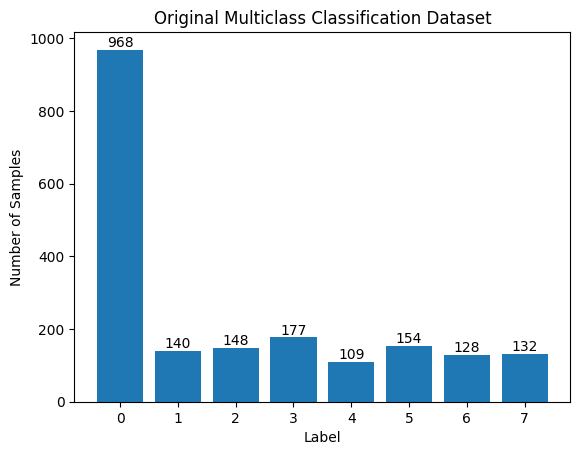

In [ ]:
label_counts = df['Family'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Original Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
df.dropna(inplace=True)

X = df.drop('Family', axis=1)
y = df['Family']

rus = RandomUnderSampler(sampling_strategy='not minority', random_state=22)

X_resampled, y_resampled = rus.fit_resample(X, y)

df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Family'])], axis=1)

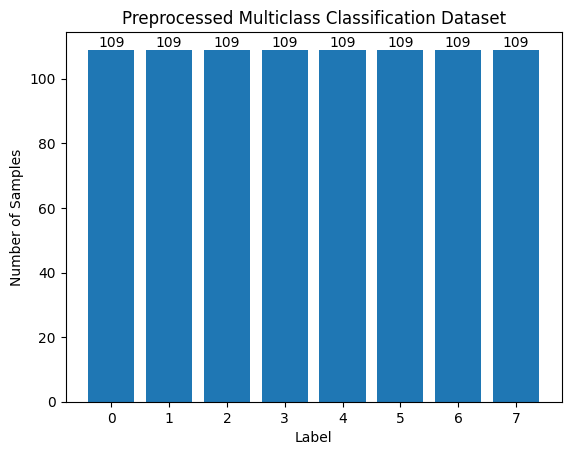

In [ ]:
label_counts = df['Family'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Preprocessed Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
data = df.to_numpy()
x = data[:, :-1].astype(float)
y = data[:, -1].astype(float)

In [ ]:
y_cat = to_categorical(y)

avg_p = []
avg_a = []
avg_r = []
avg_f = []

precision_values = []
accuracy_values = []
recall_values = []
f1_values = []

num_folds = 3

for i in range(10):
  print("Running iteration number:", i)
  kf = KFold(n_splits=num_folds, shuffle=True, random_state=22)

  precisions = []
  accuracies = []
  recalls = []
  f1s = []

  model = Sequential()
  model.add(Dense(512, input_dim=66, activation = "relu"))
  model.add(Dense(256, activation = "relu"))
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.2))
  model.add(Dense(8, activation = "softmax"))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', TopKCategoricalAccuracy(k=3)])

  fold_number = 1
  for train_index, test_index in kf.split(x):

    print(f"Fold: {fold_number}")
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y_cat[train_index], y_cat[test_index]

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=1, restore_best_weights=True)

    model.fit(x_train, y_train, verbose=1, epochs=20, batch_size=30, validation_data=(x_test, y_test), callbacks=[early_stopping])

    predict_x=model.predict(x_test)
    y_pred_class=np.argmax(predict_x,axis=1)

    y_pred = model.predict(x_test)
    y_test_class = np.argmax(y_test, axis=1)

    precision = precision_score(y_test_class, y_pred_class, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test_class, y_pred_class)
    recall = recall_score(y_test_class, y_pred_class, average='weighted', zero_division=0)
    f1 = f1_score(y_test_class, y_pred_class, average='weighted')

    print(precision, accuracy)

    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    fold_number = fold_number + 1

  avg_p.append(np.mean(precisions))
  avg_a.append(np.mean(accuracies))
  avg_r.append(np.mean(recalls))
  avg_f.append(np.mean(f1s))

  precision_values.extend(precisions)
  accuracy_values.extend(accuracies)
  recall_values.extend(recalls)
  f1_values.extend(f1s)

Running iteration number: 0
Fold: 1
Epoch 1/20
20/20 [==============================] - 4s 56ms/step - loss: 1.5973 - accuracy: 0.5559 - top_k_categorical_accuracy: 0.7831 - val_loss: 1.0514 - val_accuracy: 0.7079 - val_top_k_categorical_accuracy: 0.8866
Epoch 2/20
20/20 [==============================] - 1s 33ms/step - loss: 0.7738 - accuracy: 0.7952 - top_k_categorical_accuracy: 0.9432 - val_loss: 0.7222 - val_accuracy: 0.7663 - val_top_k_categorical_accuracy: 0.9175
Epoch 3/20
20/20 [==============================] - 0s 15ms/step - loss: 0.5804 - accuracy: 0.8434 - top_k_categorical_accuracy: 0.9570 - val_loss: 0.6063 - val_accuracy: 0.8041 - val_top_k_categorical_accuracy: 0.9519
Epoch 4/20
20/20 [==============================] - 0s 14ms/step - loss: 0.4777 - accuracy: 0.8589 - top_k_categorical_accuracy: 0.9639 - val_loss: 0.5198 - val_accuracy: 0.8385 - val_top_k_categorical_accuracy: 0.9485
Epoch 5/20
20/20 [==============================] - 0s 16ms/step - loss: 0.3844 - accura

In [ ]:
print(f'The precision values after 10 runs are -> Min: {np.min(precision_values)}, Mean: {np.mean(avg_p)}, Max: {np.max(precision_values)}, Std: {np.std(precision_values)}')
print(f'The accuracy values after 10 runs are -> Min: {np.min(accuracy_values)}, Mean: {np.mean(avg_a)}, Max: {np.max(accuracy_values)}, Std: {np.std(accuracy_values)}')
print(f'The recall values after 10 runs are -> Min: {np.min(recall_values)}, Mean: {np.mean(avg_r)}, Max: {np.max(recall_values)}, Std: {np.std(recall_values)}')
print(f'The F1 values after 10 runs are -> Min: {np.min(f1_values)}, Mean: {np.mean(avg_f)}, Max: {np.max(f1_values)}, Std: {np.std(f1_values)}')

The precision values after 10 runs are -> Min: 0.8099552108388632, Mean: 0.88259961252215, Max: 0.9299686573955346, Std: 0.0314447338848145
The accuracy values after 10 runs are -> Min: 0.7972508591065293, Mean: 0.8741181814590986, Max: 0.9241379310344827, Std: 0.03568596214429431
The recall values after 10 runs are -> Min: 0.7972508591065293, Mean: 0.8741181814590986, Max: 0.9241379310344827, Std: 0.03568596214429431
The F1 values after 10 runs are -> Min: 0.7976798066550281, Mean: 0.8739254473028897, Max: 0.9232113031643449, Std: 0.034923346905364284


# **COGLIO'S MODEL WITH COGLIO'S DATASET**

* #### **Precision:** 0.8120
* #### **Accuracy:** 0.7849
* #### **Recall:** 0.7849
* #### **F1-Score:** 0.7888
* #### **Precision Standard Deviation:** 0.018
* #### **Accuracy Standard Deviation:** 0.022
* #### **Recall Standard Deviation:** 0.022
* #### **F1-Score Standard Deviation:** 0.022

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Samples/Comparison/dataset_categorical_wo_zero.csv')
blacklist = [1,4,10,12,18,20,22,21,11,16,19]
dataset_cropped = dataset.drop(dataset[dataset['Family'].isin(blacklist)].index)

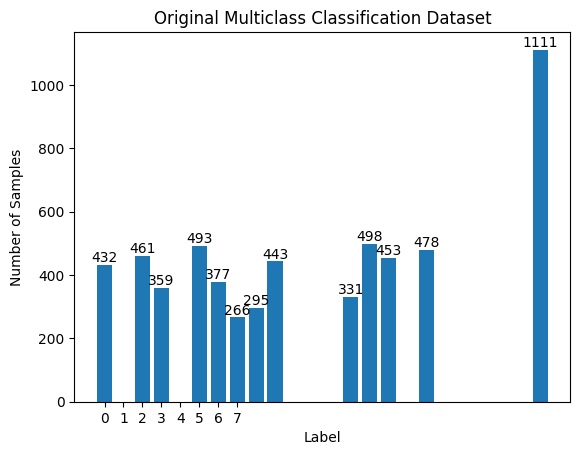

In [ ]:
label_counts = dataset_cropped['Family'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Original Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
dataset_cropped.dropna(inplace=True)

X = dataset_cropped.drop('Family', axis=1)
y = dataset_cropped['Family']

rus = RandomUnderSampler(sampling_strategy='not minority', random_state=22)

X_resampled, y_resampled = rus.fit_resample(X, y)

dataset_cropped = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Family'])], axis=1)

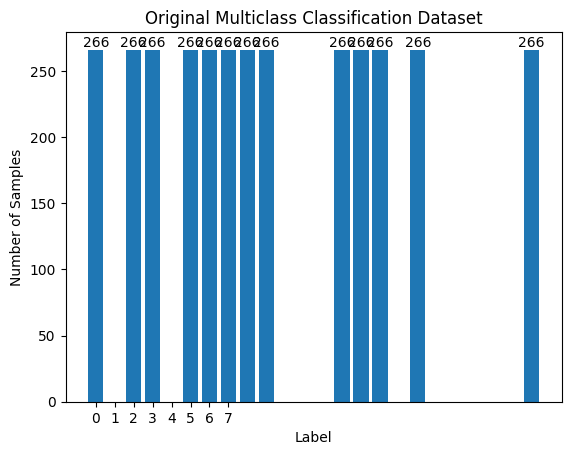

In [ ]:
label_counts = dataset_cropped['Family'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Original Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
data = dataset_cropped.to_numpy()
x = data[:, :-1].astype(float)
y = data[:, -1].astype(float)

In [ ]:
y_cat = to_categorical(y)

avg_p = []
avg_a = []
avg_r = []
avg_f = []

precision_values = []
accuracy_values = []
recall_values = []
f1_values = []

num_folds = 7

for i in range(3):
  print("Running iteration number:", i)
  kf = KFold(n_splits=num_folds, shuffle=True, random_state=22)

  precisions = []
  accuracies = []
  recalls = []
  f1s = []

  model = Sequential()
  model.add(Dense(512, input_dim=71, activation = "relu"))
  model.add(Dense(256, activation = "relu"))
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.2))
  model.add(Dense(24, activation = "softmax"))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', TopKCategoricalAccuracy(k=3)])

  fold_number = 1
  for train_index, test_index in kf.split(x):

    print(f"Fold: {fold_number}")
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y_cat[train_index], y_cat[test_index]

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

    model.fit(x_train, y_train, verbose=1, epochs=20, batch_size= 30, validation_data=(x_test, y_test), callbacks=[early_stopping])

    predict_x=model.predict(x_test)
    y_pred_class=np.argmax(predict_x,axis=1)

    y_pred = model.predict(x_test)
    y_test_class = np.argmax(y_test, axis=1)

    precision = precision_score(y_test_class, y_pred_class, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test_class, y_pred_class)
    recall = recall_score(y_test_class, y_pred_class, average='weighted', zero_division=0)
    f1 = f1_score(y_test_class, y_pred_class, average='weighted')

    print(precision, accuracy)

    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    fold_number = fold_number + 1

  avg_p.append(np.mean(precisions))
  avg_a.append(np.mean(accuracies))
  avg_r.append(np.mean(recalls))
  avg_f.append(np.mean(f1s))

  precision_values.extend(precisions)
  accuracy_values.extend(accuracies)
  recall_values.extend(recalls)
  f1_values.extend(f1s)

Running iteration number: 0
Fold: 1
Epoch 1/20
99/99 [==============================] - 3s 14ms/step - loss: 1.7500 - accuracy: 0.4983 - top_k_categorical_accuracy: 0.6859 - val_loss: 1.1169 - val_accuracy: 0.6761 - val_top_k_categorical_accuracy: 0.8259
Epoch 2/20
99/99 [==============================] - 1s 9ms/step - loss: 1.0284 - accuracy: 0.6765 - top_k_categorical_accuracy: 0.8462 - val_loss: 0.9413 - val_accuracy: 0.6943 - val_top_k_categorical_accuracy: 0.8543
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.8839 - accuracy: 0.7220 - top_k_categorical_accuracy: 0.8715 - val_loss: 0.8728 - val_accuracy: 0.7389 - val_top_k_categorical_accuracy: 0.8826
Epoch 4/20
99/99 [==============================] - 1s 11ms/step - loss: 0.8157 - accuracy: 0.7406 - top_k_categorical_accuracy: 0.8890 - val_loss: 0.8479 - val_accuracy: 0.7389 - val_top_k_categorical_accuracy: 0.8887
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 0.7640 - accurac

In [ ]:
print(f'The precision values after 10 runs are -> Min: {np.min(precision_values)}, Mean: {np.mean(avg_p)}, Max: {np.max(precision_values)}, Std: {np.std(precision_values)}')
print(f'The accuracy values after 10 runs are -> Min: {np.min(accuracy_values)}, Mean: {np.mean(avg_a)}, Max: {np.max(accuracy_values)}, Std: {np.std(accuracy_values)}')
print(f'The recall values after 10 runs are -> Min: {np.min(recall_values)}, Mean: {np.mean(avg_r)}, Max: {np.max(recall_values)}, Std: {np.std(recall_values)}')
print(f'The F1 values after 10 runs are -> Min: {np.min(f1_values)}, Mean: {np.mean(avg_f)}, Max: {np.max(f1_values)}, Std: {np.std(f1_values)}')

The precision values after 10 runs are -> Min: 0.7706352300415272, Mean: 0.8119614579703504, Max: 0.8368715244056651, Std: 0.018302887208167057
The accuracy values after 10 runs are -> Min: 0.7388663967611336, Mean: 0.7849431270483902, Max: 0.8137651821862348, Std: 0.021774566555373277
The recall values after 10 runs are -> Min: 0.7388663967611336, Mean: 0.7849431270483902, Max: 0.8137651821862348, Std: 0.021774566555373277
The F1 values after 10 runs are -> Min: 0.7397616980931135, Mean: 0.7887620765773836, Max: 0.8185004582293045, Std: 0.021987121498910082
